In [1]:
# 导入库
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import datetime
from dateutil.relativedelta import relativedelta
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')
# matplotlib绘图参数预设
config = {
            "font.family": 'serif', # 使用serif有衬线字母体系
            "mathtext.fontset": 'stix', # STIX西文字体
            "font.serif": ['SimSun'], # 宋体
            'axes.unicode_minus': False # 处理负号乱码
            }
rcParams.update(config)
%config InlineBackend.figure_format = 'svg' # notebook单元格输出的图像结果以.svg矢量图格式输出

0. 数据预处理

In [2]:
# 数据读入+格式转换（该代码仅运行一次，将.xlsx转为.pkl，提高运行速度）
pd.read_excel('./data/data.xlsx').to_pickle('./data/data.pkl')

In [3]:
df = pd.read_pickle('./data/data.pkl')
print(f'本题数据集共包含{df.size}个元素')

本题数据集共包含751100个元素


In [4]:
# 查看数据集各列数据类型
print(df.dtypes)
# 折扣转换为数值型
df['discount'] = df['discount'].fillna('10折')
df['discount'] = df['discount'].apply(lambda x : float(x.replace('折',''))/10)
# 查看数据集各列数据缺失情况
df.isnull().sum(axis=0)

date_time    datetime64[ns]
id                    int64
shop_name            object
title                object
sku_name             object
price               float64
sold                  int64
discount             object
brand                object
parameter            object
dtype: object


date_time        0
id               0
shop_name        0
title            0
sku_name     41825
price            0
sold             0
discount         0
brand        51166
parameter     2552
dtype: int64

In [5]:
'''
发现商品sku名称列（sku_name）、商品品牌列（brand）和商品参数列（parameter）存在缺失值情况
由于商品sku名称列对后续数据分析影响较小，故不对其缺失值做处理
对于商品品牌列和商品参数列，采取字符串分割、字符串关键词提取和lambda表达式三种方法对商品品牌信息做填充
'''
def BrandFill(s):
    '''
    该函数用于提取parameter列的品牌信息，并返回提取出的品牌信息字符串
    传入与传出的s均属于string类型
    '''
    try:
        s = s.split('||')
        s = [i.split(':') for i in s]
        s = [i[1] for i in s if '品牌' in i][0]
        return s
    except Exception:
        return pd.NA
def FindBrand(a,b):
    '''
    该函数用于选取每行数据的a、b两列中的字符串
    优先返回a列的字符串
    若a列值非字符串，则返回b列的字符串
    若b列值非字符串，则返回空值
    '''
    if type(a)==str:
       return a
    if type(b)==str:
        return b
    return pd.NA
# 生成新列用于储存BrandFill提取的信息，并对brand列和brand_extract列做行遍历
df['brand_extract'] = df['parameter'].apply(BrandFill)
df['brand']=df.apply(lambda x:FindBrand(x[8],x[10]), axis=1)
del df['brand_extract']
# 去除brand列和parameter列都无品牌信息的行
df=df[~df['brand'].isna()]

In [6]:
# 数据集主键选取（分析如何唯一确定一件商品）
df[df.id==3985971101463].iloc[:5,1:5].copy()
# id无法唯一确定一件商品

,id,shop_name,title,sku_name
0,3985971101463,宜度海外专营店,特价处理！超低价19.9元起！含维生素ABCDE B族B12 维生素锌硒片,维生素e 300粒--买3送1
18598,3985971101463,宜度海外专营店,特价处理！超低价39.9元起！含维生素ABCDE B族临期食品特价清仓,维生素C--美白淡斑提高免疫力--买3送1瓶
42221,3985971101463,宜度海外专营店,特价处理！超低价29.9元起！含维生素ABCDE B族B12 维生素锌硒片,维生素e 300粒--买3送1
47823,3985971101463,宜度海外专营店,特价处理！超低价39.9元起！含维生素ABCDE B族临期食品特价清仓,维生素C--美白淡斑提高免疫力--买3送1瓶
51605,3985971101463,宜度海外专营店,特价处理！超低价29.9元起！含维生素ABCDE B族B12 维生素锌硒片,维生素e 300粒--买3送1


In [7]:
# 以title作为主键
df[df.title=='买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方'].iloc[:5,1:5].copy()
# title无法唯一确定一件商品

,id,shop_name,title,sku_name
4,4363644898037,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,爱乐维玛咖锌淫羊藿胶囊140粒+爱乐维 复合维生素片30片/盒
62,4363644898037,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,套餐一
828,4349941732589,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,玛咖锌淫羊藿胶囊140粒+ 复合维生素片30片
3077,4349941732589,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,爱乐维玛咖锌淫羊藿胶囊140粒+爱乐维 复合维生素片30片
19465,4349941732589,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,玛咖锌淫羊藿胶囊140粒+ 复合维生素片30片


In [8]:
def DrugExtract(n):
    '''
    该函数用于确定唯一药品名标识
    如未找到药品名，则返回*
    '''
    try:
        n = n.split('||')
        n = [i.split(':') for i in n]
        n1 = [i[1] for i in n if '产品名称' in i][0]
        n2 = [i[1] for i in n if '药品名称' in i][0]
        n3 = [i[1] for i in n if '药品通用名' in i][0]
        if len(n3) > 0:
            return n3
        elif len(n2)>0:
            return n2
        elif len(n1)>0:
            return n1
        else:
            return '*'
    except Exception:
        return '*'
df['drug']=df['parameter'].apply(DrugExtract)
df['brand_drug'] = df['brand'] + df['drug']

In [9]:
# 存储预处理后数据
df.to_pickle('./data/data_prep.pkl')
df.to_excel('./data/data_prep.xlsx')

1. 对店铺进行分析，一共包含多少家店铺，各店铺的销售额占比如何？给出销售额占比最高的店铺，并分析该店铺销售情况。

In [10]:
df = pd.read_pickle('./data/data_prep.pkl')
# 店铺列shop_name无空值
num_shop = len(df.shop_name.unique())
print(f'本题数据集一共包含{num_shop}家店铺')
# 单个商品销售额计算
df['total_sold'] = df['price']*df['sold']*df['discount']

本题数据集一共包含26家店铺


In [11]:
# 销售额占比计算
# 单一店铺销售额计算
df1 = df.groupby('shop_name')['total_sold'].sum().reset_index().sort_values('total_sold', ascending=True).reset_index(drop=1)
# 所有店铺总销售额计算
Total_sold = df1['total_sold'].sum()
# 单一店铺销售额占比计算
df1['ratio_sold'] = df1['total_sold'].apply(lambda x : x/Total_sold)
top_shop_name = df1.iloc[-1,0]
print(f'本题数据集中销售额占比最高的店铺是“{top_shop_name}”')

本题数据集中销售额占比最高的店铺是“阿里健康大药房”


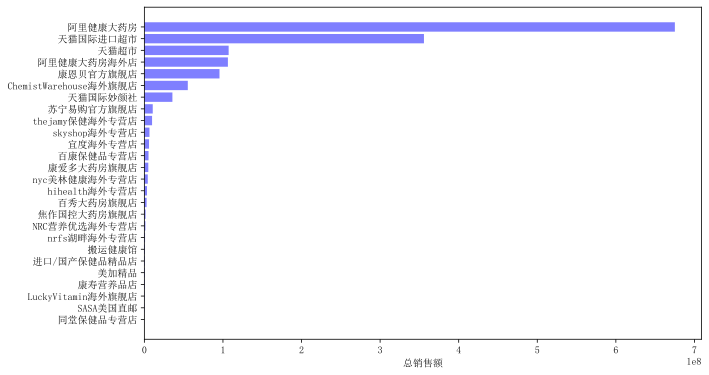

In [12]:
# 各店铺销售额条形图
plt.figure(figsize=(10,6))
temp = df1.copy()
kinds1 = temp['shop_name'].values
x = temp['total_sold'].values
y = np.arange(len(x))
plt.barh(y,x,tick_label=kinds1, color='b', alpha=0.5)
plt.xlabel('总销售额')
plt.savefig('./data/图 1 各店铺销售额.svg', format='svg', dpi=100, bbox_inches='tight')
plt.show()

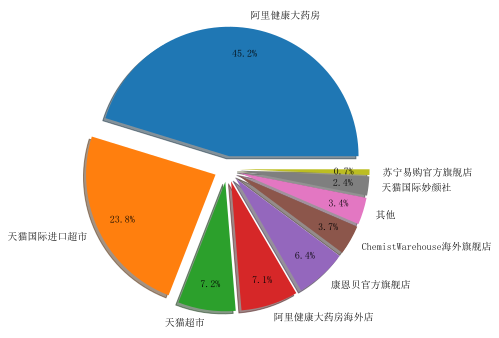

In [13]:
# 各店铺销售额占比分离饼图
temp = df1.copy()
temp = temp.sort_values('ratio_sold',ascending=0).reset_index(drop=1)
temp['shop_name'] = temp['shop_name'].apply(lambda x: x if x in kinds1[-8:] else '其他')
temp = temp.groupby('shop_name')['ratio_sold'].sum().reset_index().sort_values('ratio_sold',ascending=0).reset_index(drop=1)
kinds = temp['shop_name'].values
values = temp['ratio_sold'].values
dev_position = [0.1 for _ in range(len(kinds))]
plt.pie(values, labels=kinds, autopct='%3.1f%%', shadow=True, explode=dev_position, pctdistance=0.8, startangle=0)
plt.savefig('./data/图 2 各店铺销售额占比.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.tight_layout()

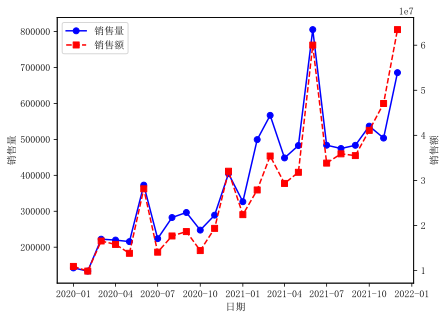

In [14]:
# “阿里健康大药房”销售情况分析-基于时间序列
top_shop = df[df['shop_name']==top_shop_name].copy()
top_shop = top_shop.reset_index(drop=1)
# 绘制阿里健康大药房每月销量与销售额折线图
temp = top_shop.groupby('date_time')['sold'].sum().reset_index()
x1 = temp['date_time'].values
y1 = temp['sold'].values
temp = top_shop.groupby('date_time')['total_sold'].sum().reset_index()
x2 = temp['date_time'].values
y2 = temp['total_sold'].values
fig = plt.figure()
ax = fig.add_subplot()
lns1 = ax.plot(x1, y1, color='b', label='销售量', marker='o', linestyle='solid')
ax.set_ylabel('销售量')
ax2 = ax.twinx()
lns2 = ax2.plot(x2, y2, color='r', label='销售额', marker='s', linestyle='dashed')
ax2.set_ylabel("销售额")
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper left")
ax.set_xlabel('日期')
plt.savefig('./data/图 3 阿里健康大药房月销售量 & 销售额折线图.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.show()

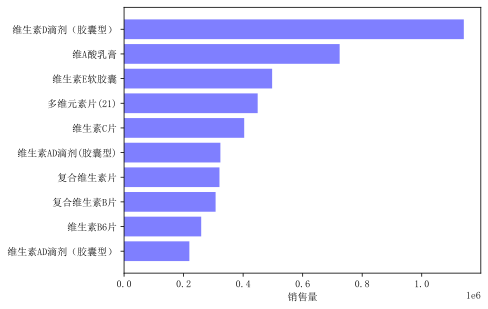

In [15]:
# “阿里健康大药房”销售情况分析-基于药品种类
# 销售量条形图
temp_num = top_shop[top_shop['drug']!='*'].groupby('drug')['sold'].sum().reset_index().sort_values('sold',ascending=1).tail(10)
kinds = temp_num['drug'].values
x = temp_num['sold'].values
y = np.arange(len(x))
plt.barh(y, x, tick_label=kinds, color='b', alpha=0.5)
plt.xlabel('销售量')
plt.savefig('./data/图 4 阿里健康大药房销售量前十药品.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.show()

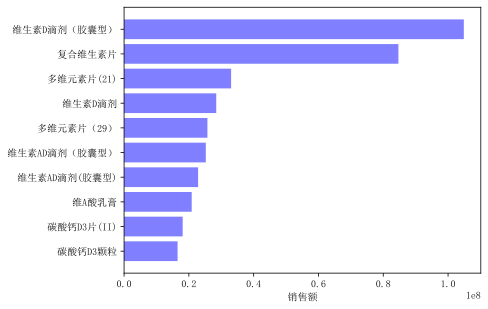

In [16]:
# 销售额条形图
temp_sale = top_shop[top_shop['drug']!='*'].groupby('drug')['total_sold'].sum().reset_index().sort_values('total_sold',ascending=1).tail(10)
kinds = temp_sale['drug'].values
x = temp_sale['total_sold'].values
y = np.arange(len(x))
plt.barh(y,x,tick_label=kinds,color='b',alpha=0.5)
plt.xlabel('销售额')
plt.savefig('./data/图 5 阿里健康大药房销售额前十药品.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.show()

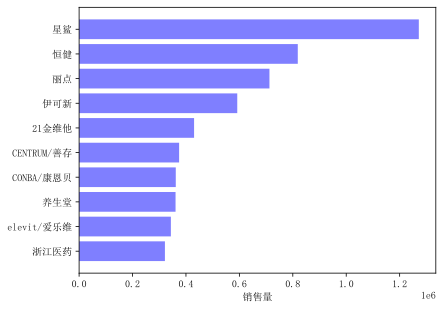

In [17]:
# “阿里健康大药房”销售情况分析-基于药品品牌
# 销售量条形图
temp_num = top_shop.groupby('brand')['sold'].sum().reset_index().sort_values('sold',ascending=1).tail(10)
kinds = temp_num['brand'].values
x = temp_num['sold'].values
y = np.arange(len(x))
plt.barh(y, x, tick_label=kinds, color='b', alpha=0.5)
plt.xlabel('销售量')
plt.savefig('./data/图 6 阿里健康大药房销售量前十药品.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.show()

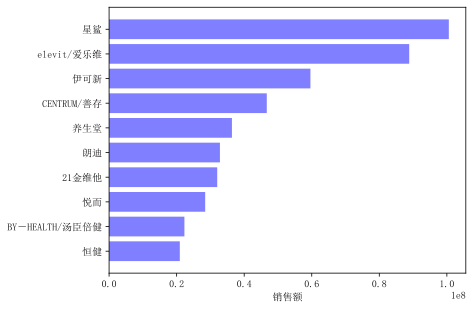

In [18]:
# 销售额条形图
temp_sale = top_shop.groupby('brand')['total_sold'].sum().reset_index().sort_values('total_sold',ascending=1).tail(10)
kinds = temp_sale['brand'].values
x = temp_sale['total_sold'].values
y = np.arange(len(x))
plt.barh(y,x,tick_label=kinds,color='b',alpha=0.5)
plt.xlabel('销售额')
plt.savefig('./data/图 7 阿里健康大药房销售额前十药品品牌.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.show()

2. 对所有药品进行分析，一共包含多少个药品，各药品的销售额占比如何？给出销售额占比最高的10个药品，并绘制这 10 个药品每月销售额曲线图。

In [19]:
# 考虑品牌不同
n1 = len(df[df['drug']!='*']['brand_drug'].unique())
# 不考虑品牌不同
n2 = len(df[df['drug']!='*']['drug'].unique())
print(f'考虑品牌的不同，有{n1}种药品；反之则有{n2}种药品')

考虑品牌的不同，有155种药品；反之则有74种药品


In [20]:
# 计算各药品的销售额占比
df2 = df[df['drug']!='*'].groupby('drug')['total_sold'].sum().reset_index()
df2 = df2.sort_values('total_sold',ascending=1).reset_index(drop=1)
Total_sold = df2['total_sold'].sum()
df2['ratio_sold'] = df2['total_sold'].apply(lambda x : x/Total_sold)

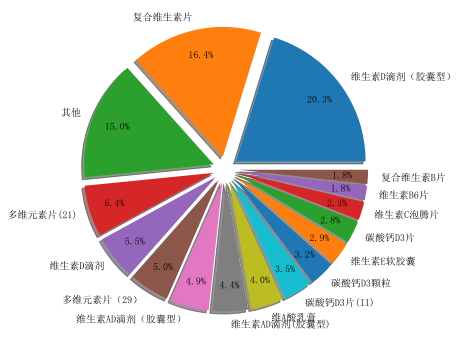

In [21]:
# 各药品销售额占比分离饼图
temp = df2.copy()
kinds1 = temp['drug'].values
x = temp['total_sold'].values
y = np.arange(len(x))
temp = df2.copy()
temp = temp.sort_values('ratio_sold',ascending=0).reset_index(drop=1)
temp['drug'] = temp['drug'].apply(lambda x: x if x in kinds1[-15:] else '其他')
temp = temp.groupby('drug')['ratio_sold'].sum().reset_index().sort_values('ratio_sold',ascending=0).reset_index(drop=1)
kinds = temp['drug'].values
values = temp['ratio_sold'].values
dev_position = [0.1 for _ in range(len(kinds))]
plt.pie(values, labels=kinds, autopct='%3.1f%%', shadow=True, explode=dev_position, pctdistance=0.8, startangle=0)
plt.savefig('./data/图 8 各药品销售额占比.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.tight_layout()

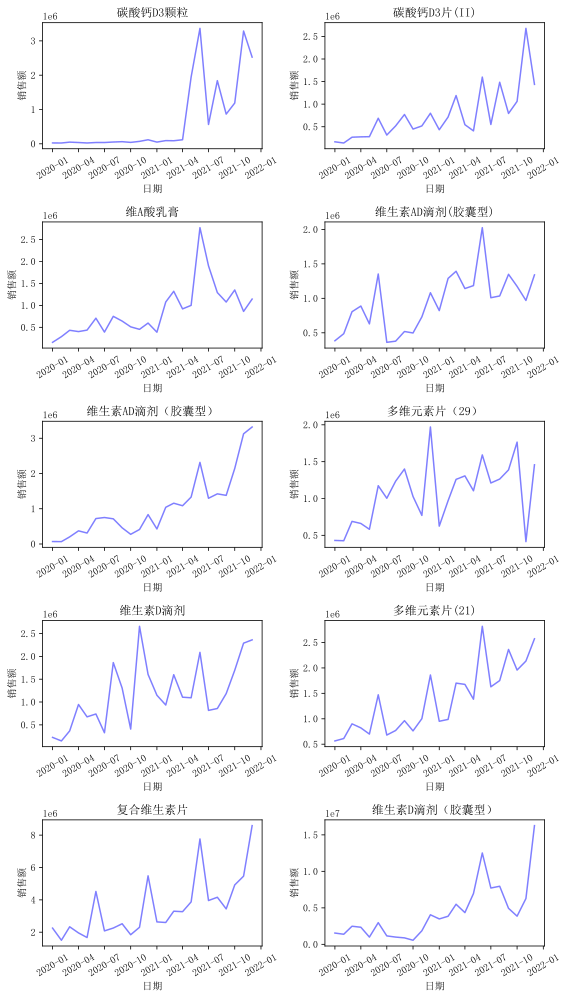

In [22]:
top_drugs = df2.tail(10)['drug'].values
plt.figure(figsize=(8,14))
for j, i in enumerate(top_drugs, start=1):
    plt.subplot(5,2,j)
    temp = df[df['drug']==i].copy()
    temp = temp.groupby('date_time')['total_sold'].sum().reset_index()
    x = temp['date_time'].values
    y = temp['total_sold'].values
    plt.plot(x, y, color='b', alpha=0.5)
    plt.xlabel('日期')
    plt.ylabel('销售额')
    plt.xticks(rotation=30)
    plt.title(i)
    plt.savefig('./data/图 9 销售额占比前十药品每月销售额折线图.svg', format='svg', dpi=100, bbox_inches = 'tight')
    plt.tight_layout()

3. 对所有药品品牌进行分析，一共包含多少个品牌，各品牌的销售额占比如何？给出销售额占比最高的10个品牌，并分析这10个品牌销售较好的原因？

In [23]:
# 初步查看品牌个数
df3 = df.copy()
num_brand = len(df3['brand'].unique())
print(f'初筛发现，一共包含{num_brand}个品牌')

初筛发现，一共包含544个品牌


In [24]:
# 观察发现，对于同一品牌，数据集中可能有时只给了中文或英文，有时中英文都有
name_brand = df3['brand'].unique()
s=[]
for i in list(name_brand.copy()):
    if '/' not in i:
        if any('\u4e00' <= _char <= '\u9fa5' for _char in i):
            s.append(['*',i])
        else:
            s.append([i,'*'])
    else:
        j,k = i.split('/')
        s.append([j, k])
name_brand = df3['brand'].unique()
t = pd.DataFrame(s)
t0 = t[0].value_counts().reset_index()
t0 = t0[t0['index']!='*']
t0 = t0[t0[0]>1]
t1 = t[1].value_counts().reset_index()
t1 = t1[t1['index']!='*']
t1 = t1[t1[1]>1]
# 含有重复英文名的品牌
t0 = t0['index'].to_list()
# 含有重复中文名的品牌
t1 = t1['index'].to_list()
tt0 = t.loc[t[0].isin(t0)].copy().sort_values([0])
tt1 = t.loc[t[1].isin(t1)].copy().sort_values([1])
print('\n下列品牌中/英文名需补全：\n', tt0, '\n\n', '下列品牌应视作同一品牌：\n', tt1)


下列品牌中/英文名需补全：
                  0     1
122  Doctor's Best     *
475  Doctor's Best   迪佰特
158            KAL   凯雷澳
451            KAL     *
25     Nature Made   天维美
56     Nature Made     *
30        OPPULAND     *
85        OPPULAND   欧普兰
135       Orthomol   奥适宝
159       Orthomol     *
22         Ostelin  奥斯特林
206        Ostelin     *
120           POLA    宝丽
284           POLA     * 

 下列品牌应视作同一品牌：
              0     1
7    BY－HEALTH  汤臣倍健
79           *  汤臣倍健
4       elevit   爱乐维
74     menevit   爱乐维
199   Dr．Herbs   禾博士
408          *   禾博士


In [25]:
# 药品品牌信息预处理
dic_brand = {  
            # 英文补中文  
              "Doctor's Best":"迪佰特",
              "KAL":"凯雷澳",
              "Nature Made":"天维美",
              "OPPULAND":"欧普兰",
              "Orthomol":"奥适宝",
              "Ostelin":"奥斯特林",
              "POLA":"宝丽",
            # 中文补英文
              "汤臣倍健":"BY－HEALTH",
              "爱乐维":"elevit",
              "禾博士":"Dr．Herbs" 
            }
def ChangeBrandInfo(s):
    '''
    该函数用于按照上述规则调整品牌列的品牌信息
    '''
    for i in dic_brand.keys():
        if i in s.split('/'):
            return f'{i}/{dic_brand[i]}'
    return s
df['brand'] = df['brand'].apply(ChangeBrandInfo)

In [26]:
# 计算处理后的药品品牌个数
df3 = df.copy()
num_brand = len(df3['brand'].unique())
name_brand = df3['brand'].unique()
print(f'本题数据集包含{num_brand}个药品品牌')

本题数据集包含534个药品品牌


In [27]:
# 计算各药品品牌的销售额占比
df3 = df3.groupby('brand')['total_sold'].sum().reset_index()
df3 = df3.sort_values('total_sold',ascending=1).reset_index(drop=1)
Total_sold = df3['total_sold'].sum()
df3['ratio_sold'] = df3['total_sold'].apply(lambda x : x/Total_sold)

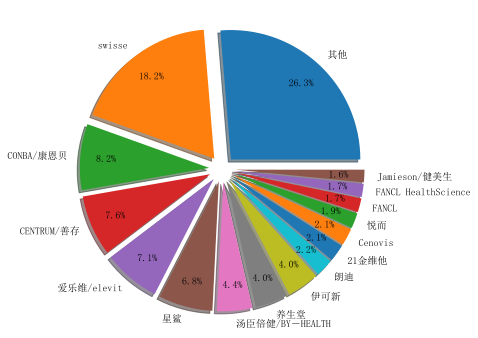

In [28]:
# 各药品品牌销售额占比分离饼图
temp = df3.copy()
kinds1 = temp.brand.values
x = temp.total_sold.values
temp = temp.sort_values('ratio_sold',ascending=0).reset_index(drop=1)
temp['brand'] = temp['brand'].apply(lambda x: x if x in kinds1[-15:] else '其他')
temp = temp.groupby('brand')['ratio_sold'].sum().reset_index().sort_values('ratio_sold',ascending=0).reset_index(drop=1)
kinds = temp['brand'].values
values = temp['ratio_sold'].values
dev_position = [0.1 for _ in range(len(kinds))]
plt.pie(values, labels=kinds, autopct='%3.1f%%', shadow=True, explode=dev_position, pctdistance=0.8, startangle=0)
plt.savefig('./data/图 10 各品牌销售额占比.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.tight_layout()

In [29]:
top_brands = list(df3.tail(10)['brand'].values)
top_brands = top_brands[::-1] 
df3.tail(10).sort_values('total_sold', ascending=0)

,brand,total_sold,ratio_sold
533,swisse,2.718398e+08,0.182201
532,CONBA/康恩贝,1.230101e+08,0.082448
531,CENTRUM/善存,1.130767e+08,0.075790
530,爱乐维/elevit,1.060953e+08,0.071110
529,星鲨,1.009440e+08,0.067658
528,汤臣倍健/BY－HEALTH,6.570113e+07,0.044036
527,养生堂,6.017866e+07,0.040335
526,伊可新,5.991355e+07,0.040157
525,朗迪,3.281707e+07,0.021996
524,21金维他,3.206686e+07,0.021493


In [30]:
# 按是否属于销售额占比前十，将药品品牌分为两类
df3 = df.copy()
df3['brand'] = df3['brand'].apply(lambda x: 'top_brand' if x in top_brands else 'other_brand')
temp = df3.copy()
del temp['id']
# 对头部品牌和其他品牌描做述性统计分析
temp = temp.groupby('brand').describe().T
for i in ['price','sold','discount','total_sold']:
    temp.loc[i].to_excel(f'./data/brand_describe_{i}.xlsx')

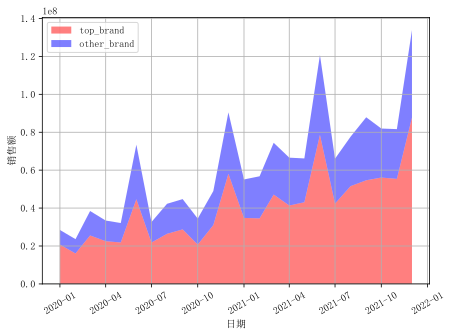

In [31]:
# 对头部品牌和其他品牌做堆积面积图
temp = df3.copy()
temp = temp.groupby(['brand','date_time'])['total_sold'].sum().reset_index()
x = temp[temp['brand']=='other_brand']['date_time'].values
y1 = temp[temp['brand']=='top_brand']['total_sold'].values
y2 = temp[temp['brand']=='other_brand']['total_sold'].values
plt.stackplot(x,y1,y2,alpha=0.5,colors=['r','b'])
plt.legend(['top_brand','other_brand'],loc='upper left')
plt.xlabel('日期')
plt.ylabel('销售额')
plt.xticks(rotation=30)
plt.savefig('./data/图 11 月销售额堆积面积折线图.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.grid()
plt.tight_layout()

4. 预测天猫维生素类药品未来三个月的销售总额并绘制拟合曲线，评估模型性能和误差。

In [32]:
# 生成训练数据集
df = pd.read_pickle('./data/data.pkl')
df['discount'] = df['discount'].fillna('10折')
df['discount'] = df['discount'].apply(lambda x : float(x.replace('折',''))/10)
df['total_sold'] = df['price']*df['sold']*df['discount']
df = df.iloc[:,[0,-1]]
df = df.groupby('date_time')['total_sold'].sum().reset_index()
df.columns = ['date','sale']
df.to_excel('./data/train.xlsx', index=None)

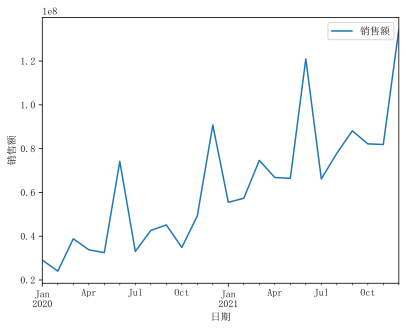

In [33]:
# 读入数据
df = pd.read_excel('./data/train.xlsx', index_col=0)
# 绘制历史月销售额折线图
df['sale'].plot(label='销售额')
plt.legend()
plt.xlabel('日期')
plt.ylabel('销售额')
plt.savefig('./data/图 12 2020-2021天猫维生素类药品销售总额.svg', format='svg', dpi=100, bbox_inches = 'tight')
plt.show()

<Figure size 640x480 with 0 Axes>

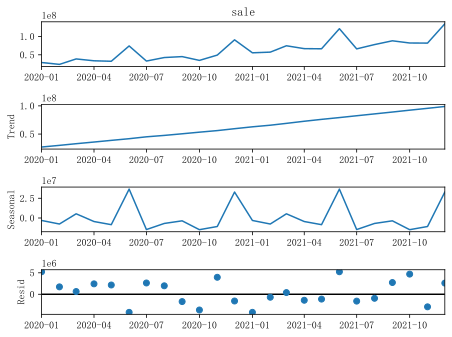

In [34]:
# 时间序列季节性分解
decomposition = seasonal_decompose(df['sale'], extrapolate_trend=6)  
fig = plt.figure()  
fig = decomposition.plot()  
plt.savefig('./data/图 13 销售总额季节性分解.svg', format='svg', dpi=100, bbox_inches = 'tight')

In [35]:
#可以分别获得趋势、季节性和随机性
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

原序列单位根检验结果：


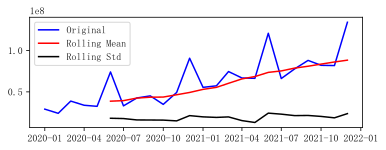

Results of Dickey-Fuller Test:
Test Statistic                  -0.258636
p-value                          0.931162
#Lags Used                       7.000000
Number of Observations Used     16.000000
Critical Value (1%)             -3.924019
Critical Value (5%)             -3.068498
Critical Value (10%)            -2.673893
AIC value                      484.713922
dtype: float64
1阶差分序列单位根检验结果：


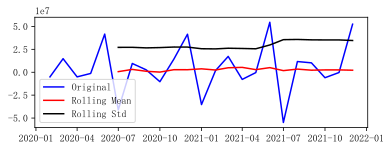

Results of Dickey-Fuller Test:
Test Statistic                -9.289110e+00
p-value                        1.193043e-15
#Lags Used                     4.000000e+00
Number of Observations Used    1.800000e+01
Critical Value (1%)           -3.859073e+00
Critical Value (5%)           -3.042046e+00
Critical Value (10%)          -2.660906e+00
AIC value                      4.561622e+02
dtype: float64
1阶差分-1阶季节性差分序列单位根检验结果：


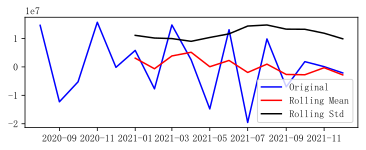

Results of Dickey-Fuller Test:
Test Statistic                -7.901756e+00
p-value                        4.167113e-12
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+01
Critical Value (1%)           -3.924019e+00
Critical Value (5%)           -3.068498e+00
Critical Value (10%)          -2.673893e+00
AIC value                      3.490179e+02
dtype: float64
对数序列单位根检验结果：


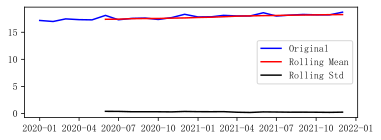

Results of Dickey-Fuller Test:
Test Statistic                 -0.427251
p-value                         0.905448
#Lags Used                      7.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
AIC value                     -20.495881
dtype: float64
对数1阶差分序列单位根检验结果：


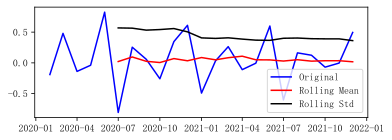

Results of Dickey-Fuller Test:
Test Statistic                -7.008758e+00
p-value                        7.010167e-10
#Lags Used                     4.000000e+00
Number of Observations Used    1.800000e+01
Critical Value (1%)           -3.859073e+00
Critical Value (5%)           -3.042046e+00
Critical Value (10%)          -2.660906e+00
AIC value                     -8.169035e+00
dtype: float64
对数1阶差分-1阶季节性差分序列单位根检验结果：


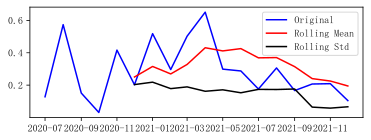

Results of Dickey-Fuller Test:
Test Statistic                 -3.870804
p-value                         0.002261
#Lags Used                      0.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
AIC value                      -6.971085
dtype: float64


In [36]:
# 对序列做平稳性检验
def test_stationarity(timeseries):
    '''
    该函数用于构建具有可视化图像与清晰输出结果的ADF检验
    '''
    # 生成滚动统计量
    rolmean = timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).std()
    # 绘制滚动统计量
    fig = plt.figure(figsize=(6, 2))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()
    # 打印ADF检验结果
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  # autolag可选参数 : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    dfoutput['AIC value'] = dftest[5]
    print(dfoutput)
# 原序列
print('原序列单位根检验结果：')
test_stationarity(df['sale'])
# 1阶差分序列
df['first_difference'] = df['sale'] - df['sale'].shift(1)
print('1阶差分序列单位根检验结果：')
test_stationarity(df.first_difference.dropna(inplace=False))
# 1阶差分-1阶季节性差分序列
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(6)
print('1阶差分-1阶季节性差分序列单位根检验结果：')
test_stationarity(df['seasonal_first_difference'].dropna(inplace=False))
# 对数序列
df['sale_log'] = df.sale.apply(lambda x: np.log(x))
print('对数序列单位根检验结果：')
test_stationarity(df['sale_log'])
# 对数1阶差分序列
df['log_first_difference'] = df['sale_log'] - df['sale_log'].shift(1)
print('对数1阶差分序列单位根检验结果：')
test_stationarity(df['log_first_difference'].dropna(inplace=False))
# 对数1阶差分-1阶季节性差分序列
df['log_seasonal_difference'] = df['sale_log'] - df['sale_log'].shift(6)
print('对数1阶差分-1阶季节性差分序列单位根检验结果：')
test_stationarity(df['log_seasonal_difference'].dropna(inplace=False))

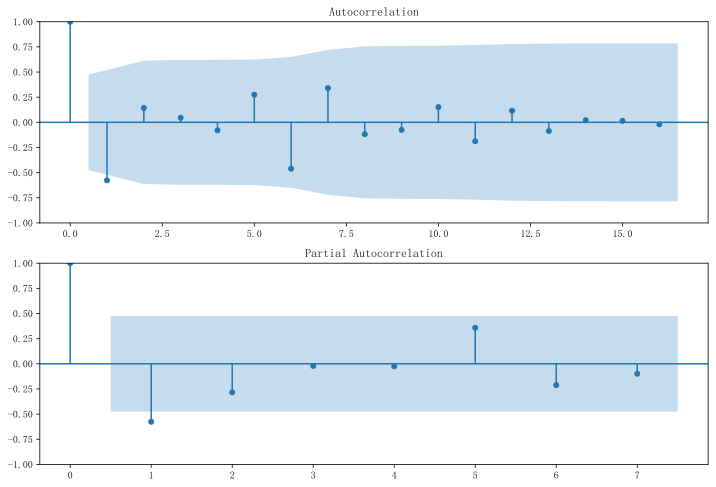

In [37]:
# 自（偏）相关性分析
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['seasonal_first_difference'].iloc[7:], ax=ax1, lags=16)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['seasonal_first_difference'].iloc[7:], ax=ax2, method='ywm', lags=7)
plt.savefig('./data/图 14 销售总额1阶差分-1阶季节性序列的ACF图 & PACF图.svg', format='svg', dpi=100, bbox_inches = 'tight')

In [38]:
# 模型拟合
mod = sm.tsa.statespace.SARIMAX(df['sale'], trend='n', order=(2,1,2), seasonal_order=(2,1,0,6))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               sale   No. Observations:                   24
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 6)   Log Likelihood                -284.702
Date:                            Thu, 05 Jan 2023   AIC                            583.404
Time:                                    14:42:46   BIC                            589.236
Sample:                                01-01-2020   HQIC                           583.984
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1100      0.311     -0.353      0.724      -0.721       0.501
ar.L2         -0.7427      0.273     -2.719      0.007      -1.278      -0.207
ma.L1          0.0450      0.152      0.296      0.767      -0.252       0.342
ma.L2          0.9652      0.391      2.471      0.013       0.200       1.731
ar.S.L6       -0.0867      0.437     -0.199      0.843      -0.943       0.769
ar.S.L12       0.2844      0.717      0.397      0.692      -1.121       1.690
sigma2      4.006e+13   9.43e-15   4.25e+27      0.000    4.01e+13    4.01e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 3.50
Prob(Q):                              0.62   Prob(JB):                         0.17
Heteroskedasticity (H):               2.23   Skew:                            -1.00
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.29e+43. Standard errors may be unstable.
"""

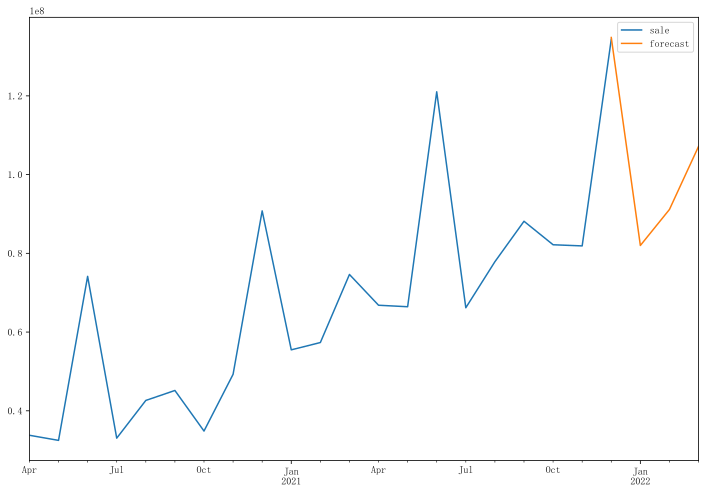

In [39]:
# 生成待预测月份
start = datetime.datetime.strptime("2022-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,3)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])
# 模型预测
df['forecast'] = results.predict(start = 23, end = 27, dynamic= True)  
df.to_excel('./data/SARIMA_forecast.xlsx')
df[['sale', 'forecast']].iloc[-24:].plot(figsize=(12, 8)) 
plt.savefig('./data/图 15 SARIMA(2, 1, 2)(2, 1, 0, 6)销售总额预测结果.svg', format='svg', dpi=100, bbox_inches = 'tight')